# Riverbed Erosion

Demonstration of using Gerabaldi's advanced stochastic model and degradation model agnosticism to simulate degradation of other processes beyond integrated circuits; in this case fluvial erosion in rivers.

---------------------------------------------------------------------------------------------------------------------------

Copyright (c) 2023 Ian Hill

SPDX-License-Identifier: Apache-2.0

## 0. Library Installation

In [1]:
pip install gerabaldi

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gerabaldi 
from gerabaldi.models import * 
from gerabaldi.helpers import _on_demand_import

import seaborn as sb
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

## 1. Functions Definition

In [3]:
def simulate(save_file: str = None):
    
    SECONDS_PER_HOUR = 3600
    HOURS_PER_YEAR = 8760

    ########################################################################
    ### 1. Define the fluvial erosion stress and monitoring process/test ###
    ########################################################################
    # Note that 'tau' is the shear stress due to the flow of river water over the soil bed
    erosion_meas = MeasSpec({'riverbed_level': SAMPLES_PER_RIVER}, {'tau': 3}, 'Bed Height Sampling')
    # Each stress phase lasts a quarter of a year
    summer_strs = StrsSpec({'tau': 4}, HOURS_PER_YEAR / 4, 'Summer Season Flow')
    autumn_strs = StrsSpec({'tau': 2}, HOURS_PER_YEAR / 4, 'Autumn Season Flow')
    winter_strs = StrsSpec({'tau': 2}, HOURS_PER_YEAR / 4, 'Winter Season Flow')
    spring_strs = StrsSpec({'tau': 7}, HOURS_PER_YEAR / 4, 'Spring Season Flow')
    # We will measure 20 individual locations in 5 different rivers for 10 years
    ten_year_test = TestSpec([erosion_meas], RIVERS_SAMPLED, 1, name='Riverbed Erosion Process')
    ten_year_test.append_steps([spring_strs, summer_strs, autumn_strs, winter_strs, erosion_meas], HOURS_PER_YEAR * 10)

    ########################################################################
    ### 2. Define the test/field environment                             ###
    ########################################################################
    river_env = PhysTestEnv(env_vrtns={
        # The shear stress varies between riverbed locations a bit, but much more so between distinct rivers
        'tau': EnvVrtnMdl(dev_vrtn_mdl=Normal(0, 0.2), chp_vrtn_mdl=Normal(0, 0.8), batch_vrtn_mdl=Normal(0, 1.2)),
    }, meas_instms={
        # We can only measure to the nearest centimetre, and our measurements are typically off by half a centimetre
        'riverbed_level': MeasInstrument(precision=3, error=Normal(0, 0.005))
    })

    ########################################################################
    ### 3. Define the physical riverbed erosion model                    ###
    ########################################################################
    # Model provided in K. Klavon et al. BSTEM paper, Equation 3, DOI: https://doi.org/10.1002/esp.4073
    # Tau represents the amount of shear stress, tau_c is the critical stress threshold for erosion to occur
    def fluvial_erosion_riverbed(time, k_d, tau_c, alpha, tau):
        e_r = np.maximum(k_d * ((alpha * tau) - tau_c), 0)
        return time * e_r

    def riverbed_level(init, erosion, cond):
        return init - erosion + cond

    river_mdl = DeviceMdl(DegPrmMdl(
        prm_name='riverbed_level',
        deg_mech_mdls={
            'erosion': DegMechMdl(
                fluvial_erosion_riverbed, k_d=LatentVar(deter_val=1e-5),
                tau_c=LatentVar(Normal(2.4, 0.02), Normal(1, 0.2)), alpha=LatentVar(Normal(0.9, 0.01), Normal(1, 0.04)),
            )},
        init_val_mdl=InitValMdl(init_val=LatentVar(dev_vrtn_mdl=Normal(-2, 0.01), chp_vrtn_mdl=Normal(1, 0.02))),
        compute_eqn=riverbed_level,
        array_computable=False
    ))

    ########################################################################
    ### 4. Simulate the riverbed erosion over the specified time period  ###
    ########################################################################
    erosion_report = gerabaldi.simulate(ten_year_test, river_mdl, river_env)

    # Save the simulated results to a JSON file for reuse if desired
    if save_file:
        erosion_report.export_to_json(save_file, 'hours')
    return erosion_report


def visualize(report):
    
    SECONDS_PER_HOUR = 3600
    HOURS_PER_YEAR = 8760
    
    measured = report.measurements

    # Reformat dataframe to get ready for plotting
    measured = measured.set_index(['param', 'device #', 'chip #'])
    measured = measured.sort_index()
    measured = measured.drop('lot #', axis=1)
    # Change time deltas to hours then years for processing
    measured['time'] = measured['time'].apply(lambda time, **kwargs: time.total_seconds() / SECONDS_PER_HOUR, axis=1)
    measured['time'] = measured['time'] / HOURS_PER_YEAR

    # Set up the plots
    sb.set_theme(style='whitegrid', font='Times New Roman')
    sb.set_context('talk')
    f1, p1 = plt.subplots(figsize=(8, 6))
    f2, p2 = plt.subplots(figsize=(8, 6))

    # Now extract each individual series of measurements in turn
    colour_map = ['mediumpurple', 'green', 'cornflowerblue', 'aqua', 'limegreen']
    for rvr in range(RIVERS_SAMPLED):
        avg = np.zeros(11)
        max_val = np.full(11, -1000)
        min_val = np.full(11, 1000)
        times = measured.loc['riverbed_level', 0, 0]['time']

        for smpl in range(SAMPLES_PER_RIVER):
            # First plot the individual series
            meas = measured.loc[('riverbed_level', smpl, rvr)]
            p1.plot(meas['time'], meas['measured'], color=colour_map[rvr])
            # Also plot the average level for each time in each river, along with the spread of values
            vals = meas.reset_index()['measured']
            avg += vals
            max_val = np.maximum(max_val, vals)
            min_val = np.minimum(min_val, vals)

        avg = avg / SAMPLES_PER_RIVER
        p2.plot(times, avg, color=colour_map[rvr])
        p2.fill_between(times, min_val, max_val, color=colour_map[rvr], alpha=0.2)

    p1.set(ylabel='Riverbed Level Below Ref (metres)', xlabel='Elapsed Time (years)',
           title='Riverbed Erosion in Five Glacier-Fed Streams')
    p2.set(ylabel='Riverbed Level Below Reference (metres)', xlabel='Elapsed Time (years)', xlim=(0, 10),
           title='Riverbed Erosion in Glacial Runoff Streams')
    p2.grid(alpha=0.2)
    p2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    sb.despine()
    plt.show()

## 2. Outputs

In [4]:
# Global Variables

DATA_FILE_NAME = 'erosion_report'
SAMPLES_PER_RIVER = 10
RIVERS_SAMPLED = 5

In [5]:
report = simulate()

### 2.1 Measurements DataFrame 

In [6]:
report.measurements.head(10)

,param,device #,chip #,lot #,time,measured
0,riverbed_level,0,0,0,0 days,-2.01
1,riverbed_level,1,0,0,0 days,-2.02
2,riverbed_level,2,0,0,0 days,-2.06
3,riverbed_level,3,0,0,0 days,-2.02
4,riverbed_level,4,0,0,0 days,-2.02
5,riverbed_level,5,0,0,0 days,-2.04
6,riverbed_level,6,0,0,0 days,-2.03
7,riverbed_level,7,0,0,0 days,-2.02
8,riverbed_level,8,0,0,0 days,-2.04
9,riverbed_level,9,0,0,0 days,-2.05


In [7]:
report.stress_summary.head(10)

,stress step,duration,start time,end time,tau
0,Spring Season Flow,91 days 06:00:00,0 days 00:00:00,91 days 06:00:00,7
1,Summer Season Flow,91 days 06:00:00,91 days 06:00:00,182 days 12:00:00,4
2,Autumn Season Flow,91 days 06:00:00,182 days 12:00:00,273 days 18:00:00,2
3,Winter Season Flow,91 days 06:00:00,273 days 18:00:00,365 days 00:00:00,2
4,Spring Season Flow,91 days 06:00:00,365 days 00:00:00,456 days 06:00:00,7
5,Summer Season Flow,91 days 06:00:00,456 days 06:00:00,547 days 12:00:00,4
6,Autumn Season Flow,91 days 06:00:00,547 days 12:00:00,638 days 18:00:00,2
7,Winter Season Flow,91 days 06:00:00,638 days 18:00:00,730 days 00:00:00,2
8,Spring Season Flow,91 days 06:00:00,730 days 00:00:00,821 days 06:00:00,7
9,Summer Season Flow,91 days 06:00:00,821 days 06:00:00,912 days 12:00:00,4


### 2.2 Report Visualization 

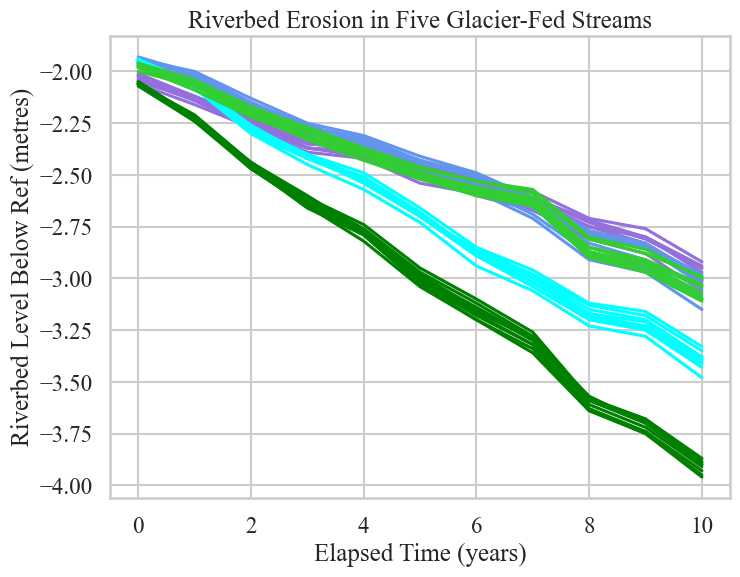

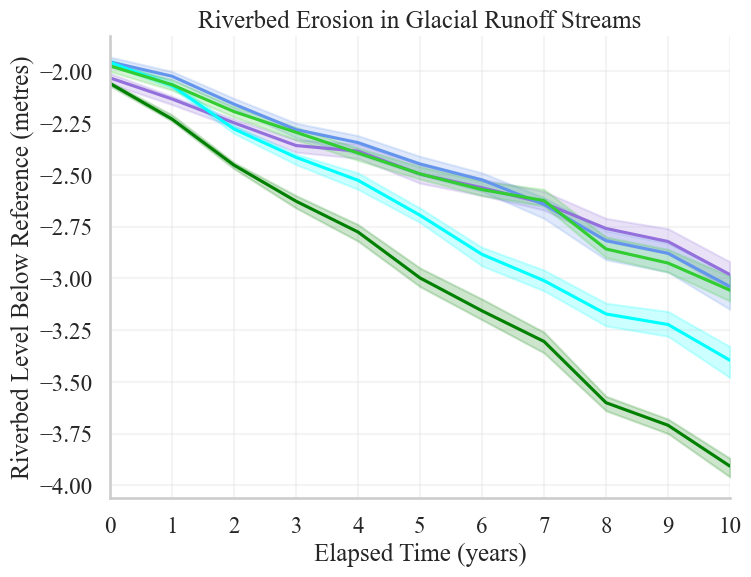

In [8]:
visualize(report)